In [1]:
#80
#途中まで50と同じ

#データダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-01-30 16:12:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  14.8MB/s    in 1.9s    

2022-01-30 16:12:29 (14.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']) #具体例からこのように分ける

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']] #publisherが”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”であるものの、そのカテゴリ名と記事見出しを抽出 isin https://vector-ium.com/pandas-isin/  loc(列ラベル) https://note.nkmk.me/python-pandas-at-iat-loc-iloc/

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['CATEGORY']) #学習データ80%とその他20%に分ける train_test_splitについて https://qiita.com/KyleKatarn/items/2afa6787f04f28e2cd2d
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=42, stratify=valid_test['CATEGORY']) #その他に分けられたデータを半分ずつ検証データと評価データに分類(全体から見ると10%,10%)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [4]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('---頻度上位20語---')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]} 出現回数:{d[word2id[key]-1][1]}')

ID数: 9374

---頻度上位20語---
to: 1 出現回数:2141
s: 2 出現回数:1907
in: 3 出現回数:1423
UPDATE: 4 出現回数:1074
on: 5 出現回数:1065
as: 6 出現回数:1018
US: 7 出現回数:998
The: 8 出現回数:975
of: 9 出現回数:967
for: 10 出現回数:942
1: 11 出現回数:860
To: 12 出現回数:737
2: 13 出現回数:678
the: 14 出現回数:611
and: 15 出現回数:577
In: 16 出現回数:509
Of: 17 出現回数:478
at: 18 出現回数:466
a: 19 出現回数:449
A: 20 出現回数:442


### defaultdictについて
https://qiita.com/xza/items/

In [5]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [6]:
#確認
text = train.iloc[0, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: UPDATE 1-Sandwich chain Quiznos files for bankruptcy protection
ID列: [4, 11, 0, 1717, 0, 790, 10, 1238, 3532]


In [7]:
#81
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out
    
  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
    return hidden

In [8]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [9]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 195,  557, 1078,  389, 3022,   87,  288,  605,   94,   41, 2657,  214])
  labels: 0


In [10]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# デバイスの指定
device = torch.device("cpu")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2002, 0.1881, 0.4442, 0.1675]], grad_fn=<SoftmaxBackward>)
tensor([[0.2572, 0.1767, 0.2209, 0.3452]], grad_fn=<SoftmaxBackward>)
tensor([[0.1384, 0.1692, 0.2700, 0.4224]], grad_fn=<SoftmaxBackward>)
tensor([[0.2864, 0.2315, 0.3094, 0.1727]], grad_fn=<SoftmaxBackward>)
tensor([[0.3836, 0.1411, 0.3698, 0.1055]], grad_fn=<SoftmaxBackward>)
tensor([[0.3987, 0.2660, 0.1305, 0.2049]], grad_fn=<SoftmaxBackward>)
tensor([[0.3175, 0.2368, 0.2245, 0.2211]], grad_fn=<SoftmaxBackward>)
tensor([[0.2527, 0.2921, 0.1963, 0.2590]], grad_fn=<SoftmaxBackward>)
tensor([[0.4239, 0.1625, 0.1527, 0.2609]], grad_fn=<SoftmaxBackward>)
tensor([[0.2733, 0.2108, 0.1451, 0.3708]], grad_fn=<SoftmaxBackward>)


In [11]:
#82
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
        
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [12]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [13]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device("cpu")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

epoch: 1, loss_train: 1.1052, accuracy_train: 0.5209, loss_valid: 1.1255, accuracy_valid: 0.5195, 65.5820sec
epoch: 2, loss_train: 1.0197, accuracy_train: 0.5899, loss_valid: 1.0633, accuracy_valid: 0.5726, 70.7429sec
epoch: 3, loss_train: 0.8792, accuracy_train: 0.6722, loss_valid: 0.9464, accuracy_valid: 0.6497, 64.4233sec
epoch: 4, loss_train: 0.7269, accuracy_train: 0.7397, loss_valid: 0.8351, accuracy_valid: 0.7021, 71.4232sec
epoch: 5, loss_train: 0.6323, accuracy_train: 0.7756, loss_valid: 0.7665, accuracy_valid: 0.7320, 63.7325sec
epoch: 6, loss_train: 0.5615, accuracy_train: 0.7974, loss_valid: 0.7191, accuracy_valid: 0.7433, 72.6375sec
epoch: 7, loss_train: 0.5074, accuracy_train: 0.8157, loss_valid: 0.6877, accuracy_valid: 0.7493, 72.9867sec
epoch: 8, loss_train: 0.4868, accuracy_train: 0.8230, loss_valid: 0.6816, accuracy_valid: 0.7575, 72.8820sec
epoch: 9, loss_train: 0.4644, accuracy_train: 0.8327, loss_valid: 0.6739, accuracy_valid: 0.7552, 63.5258sec
epoch: 10, loss_tra

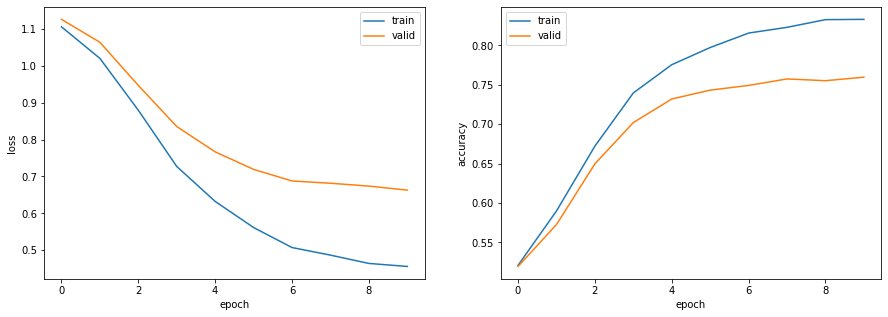

正解率（学習データ）：0.833
正解率（評価データ）：0.772


In [14]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [15]:
#83
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

## GPUの確認

In [16]:
!nvidia-smi

Sun Jan 30 16:24:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   24C    P8     8W / 250W |      8MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN X ...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [17]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device("cuda")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2604, accuracy_train: 0.4056, loss_valid: 1.2629, accuracy_valid: 0.4072, 10.0428sec
epoch: 2, loss_train: 1.2696, accuracy_train: 0.4086, loss_valid: 1.2843, accuracy_valid: 0.4019, 10.0283sec
epoch: 3, loss_train: 1.1659, accuracy_train: 0.4963, loss_valid: 1.1762, accuracy_valid: 0.4798, 9.9935sec
epoch: 4, loss_train: 1.0956, accuracy_train: 0.5671, loss_valid: 1.1211, accuracy_valid: 0.5240, 10.1462sec
epoch: 5, loss_train: 1.0144, accuracy_train: 0.6353, loss_valid: 1.0663, accuracy_valid: 0.5861, 10.7708sec
epoch: 6, loss_train: 0.9934, accuracy_train: 0.6465, loss_valid: 1.0409, accuracy_valid: 0.5921, 10.7953sec
epoch: 7, loss_train: 0.9584, accuracy_train: 0.6660, loss_valid: 1.0156, accuracy_valid: 0.6115, 10.1055sec
epoch: 8, loss_train: 0.9278, accuracy_train: 0.6846, loss_valid: 0.9840, accuracy_valid: 0.6295, 10.0323sec
epoch: 9, loss_train: 0.8989, accuracy_train: 0.6982, loss_valid: 0.9677, accuracy_valid: 0.6310, 10.0533sec
epoch: 10, loss_trai

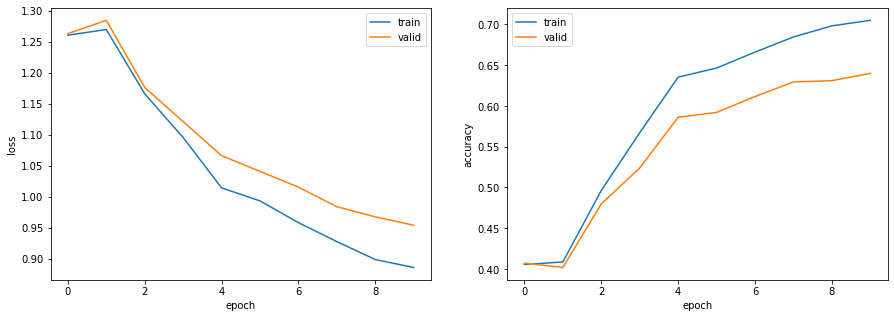

正解率（学習データ）：0.705
正解率（評価データ）：0.661


In [18]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [19]:
#84
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2022-01-30 16:26:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.73.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.73.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  17.4MB/s    in 1m 55s  

2022-01-30 16:28:03 (13.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [20]:
!pip install gensim

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 24.1 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 11.4 MB/s eta 0:00:01
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [21]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = torch.tensor(model[word])
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9130 / 9375
torch.Size([9375, 300])


In [22]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden() # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(device)
    return hidden

In [23]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1695, accuracy_train: 0.4334, loss_valid: 1.1703, accuracy_valid: 0.4341, 10.5173sec
epoch: 2, loss_train: 1.1243, accuracy_train: 0.5177, loss_valid: 1.1461, accuracy_valid: 0.4955, 10.2129sec
epoch: 3, loss_train: 1.0495, accuracy_train: 0.6012, loss_valid: 1.0725, accuracy_valid: 0.5793, 10.1368sec
epoch: 4, loss_train: 1.0171, accuracy_train: 0.6340, loss_valid: 1.0453, accuracy_valid: 0.6055, 10.1480sec
epoch: 5, loss_train: 1.0453, accuracy_train: 0.6014, loss_valid: 1.0933, accuracy_valid: 0.5786, 10.1659sec
epoch: 6, loss_train: 1.0462, accuracy_train: 0.5979, loss_valid: 1.0806, accuracy_valid: 0.5734, 10.1781sec
epoch: 7, loss_train: 0.9947, accuracy_train: 0.6326, loss_valid: 1.0390, accuracy_valid: 0.6018, 10.1465sec
epoch: 8, loss_train: 0.9435, accuracy_train: 0.6628, loss_valid: 0.9770, accuracy_valid: 0.6400, 10.1524sec
epoch: 9, loss_train: 0.9380, accuracy_train: 0.6633, loss_valid: 0.9788, accuracy_valid: 0.6317, 10.1998sec
epoch: 10, loss_tra

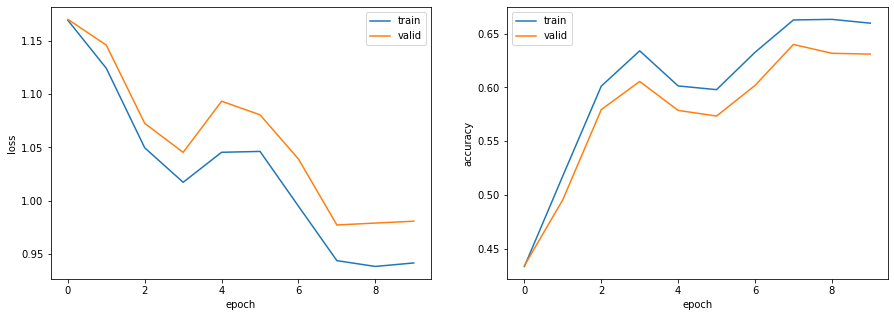

正解率（学習データ）：0.660
正解率（評価データ）：0.650


In [24]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [25]:
#85
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1634, accuracy_train: 0.4320, loss_valid: 1.1697, accuracy_valid: 0.4244, 16.6420sec
epoch: 2, loss_train: 1.1332, accuracy_train: 0.5201, loss_valid: 1.1867, accuracy_valid: 0.4895, 16.7660sec
epoch: 3, loss_train: 1.1028, accuracy_train: 0.5432, loss_valid: 1.1435, accuracy_valid: 0.5187, 16.1593sec
epoch: 4, loss_train: 1.0508, accuracy_train: 0.6018, loss_valid: 1.1057, accuracy_valid: 0.5636, 16.5220sec
epoch: 5, loss_train: 1.1369, accuracy_train: 0.5590, loss_valid: 1.1901, accuracy_valid: 0.5404, 16.0659sec
epoch: 6, loss_train: 1.0243, accuracy_train: 0.6200, loss_valid: 1.1106, accuracy_valid: 0.5838, 16.1330sec
epoch: 7, loss_train: 0.9550, accuracy_train: 0.6432, loss_valid: 1.0346, accuracy_valid: 0.6025, 16.4069sec
epoch: 8, loss_train: 0.9688, accuracy_train: 0.6409, loss_valid: 1.0576, accuracy_valid: 0.6040, 16.1417sec
epoch: 9, loss_train: 0.9592, accuracy_train: 0.6460, loss_valid: 1.0543, accuracy_valid: 0.6108, 16.8892sec
epoch: 10, loss_tra

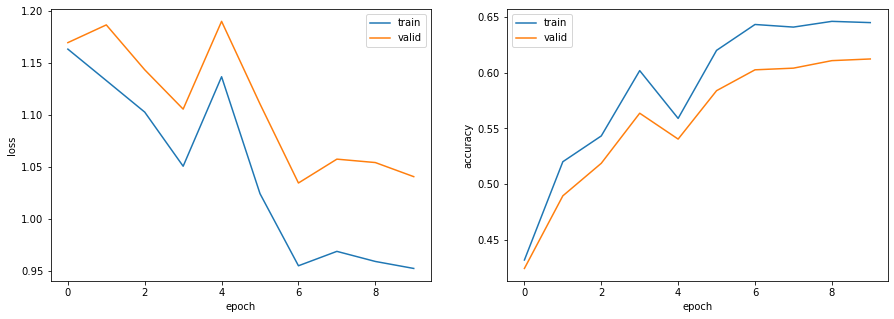

正解率（学習データ）：0.645
正解率（評価データ）：0.635


In [26]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [27]:
#86

from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [28]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2229, 0.3275, 0.1748, 0.2748]], grad_fn=<SoftmaxBackward>)
tensor([[0.2635, 0.2269, 0.2131, 0.2965]], grad_fn=<SoftmaxBackward>)
tensor([[0.2216, 0.2451, 0.1980, 0.3353]], grad_fn=<SoftmaxBackward>)
tensor([[0.2412, 0.2842, 0.2107, 0.2638]], grad_fn=<SoftmaxBackward>)
tensor([[0.2485, 0.2746, 0.2039, 0.2730]], grad_fn=<SoftmaxBackward>)
tensor([[0.2696, 0.2742, 0.1877, 0.2684]], grad_fn=<SoftmaxBackward>)
tensor([[0.2590, 0.2768, 0.1879, 0.2762]], grad_fn=<SoftmaxBackward>)
tensor([[0.2565, 0.2441, 0.2106, 0.2888]], grad_fn=<SoftmaxBackward>)
tensor([[0.2450, 0.2529, 0.2219, 0.2802]], grad_fn=<SoftmaxBackward>)
tensor([[0.2064, 0.2359, 0.2488, 0.3089]], grad_fn=<SoftmaxBackward>)


In [29]:
#87

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0728, accuracy_train: 0.5572, loss_valid: 1.0893, accuracy_valid: 0.5531, 7.9598sec
epoch: 2, loss_train: 0.9988, accuracy_train: 0.6246, loss_valid: 1.0329, accuracy_valid: 0.6010, 7.9088sec
epoch: 3, loss_train: 0.9244, accuracy_train: 0.6797, loss_valid: 0.9731, accuracy_valid: 0.6400, 7.8834sec
epoch: 4, loss_train: 0.8622, accuracy_train: 0.7085, loss_valid: 0.9268, accuracy_valid: 0.6654, 7.8559sec
epoch: 5, loss_train: 0.8163, accuracy_train: 0.7221, loss_valid: 0.8900, accuracy_valid: 0.6744, 7.8554sec
epoch: 6, loss_train: 0.7848, accuracy_train: 0.7367, loss_valid: 0.8710, accuracy_valid: 0.6916, 7.8573sec
epoch: 7, loss_train: 0.7621, accuracy_train: 0.7421, loss_valid: 0.8552, accuracy_valid: 0.6976, 7.8268sec
epoch: 8, loss_train: 0.7494, accuracy_train: 0.7459, loss_valid: 0.8458, accuracy_valid: 0.7028, 7.8381sec
epoch: 9, loss_train: 0.7437, accuracy_train: 0.7471, loss_valid: 0.8422, accuracy_valid: 0.7028, 7.8611sec
epoch: 10, loss_train: 0.742

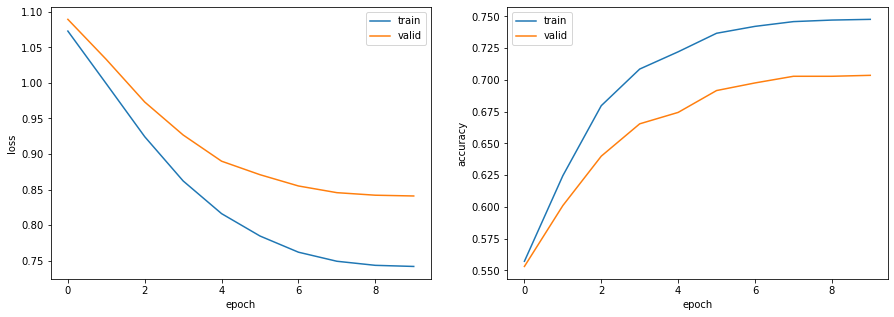

正解率（学習データ）：0.748
正解率（評価データ）：0.707


In [30]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## #88
まず #85のハイパーパラメータ探索を行う

In [31]:
!pip install optuna

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 308 kB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 22.6 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 18.7 MB/s eta 0:00:01
     |████████████████████████████████| 149 kB 42.5 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 42.4 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=162f965532b651244ab6300e3e2f4979feb3a18f550a43e1dd09ab149597e0fb
  Stored in directory: /home/jovyan/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [32]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [33]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden() # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(device)
    return hidden

In [34]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率を返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=num_eta_min, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    
    # 終了時刻の記録
    e_time = time.time()
    
    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 
    
    
    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return log_train, log_valid



def display_train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率を返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=num_eta_min, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    
    # 終了時刻の記録
    e_time = time.time()
    
    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 
    
    
    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [37]:
import optuna

def Get_Optimizer(trial, model): #optimizerの最適化関数
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD']) 
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) #学習率の初期値を変更
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    return optimizer

# デバイスの指定
device = torch.device('cuda')

def objective(trial): 
       
    # デバイスの指定
    device = torch.device('cuda')
    
    #パラメータの設定(小文字はハイパーパラメータチューニングを行う)
    VOCAB_SIZE = len(set(word2id.values())) + 1
    EMB_SIZE =300
    PADDING_IDX = len(set(word2id.values()))
    OUTPUT_SIZE = 4
    hidden_size = int(trial.suggest_discrete_uniform('hidden_size', 10, 100, 10))
    #hidden_size = 50
    num_layers = int(trial.suggest_discrete_uniform('num_layers', 2, 5, 1))
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 64, 1024, 64)) #適切なバッチサイズを64-1024の間で64刻みで探す
    #num_epochs = trial.suggest_int('num_epochs', 5, 50) #適切なエポック数を探す
    num_epochs = 10
    num_eta_min = trial.suggest_loguniform('min_lr', 1e-5, 1e-1)#スケジューラの学習率の最小値
    
    
    # モデルの定義
    model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weights, bidirectional=True)
    
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    
    # オプティマイザの定義
    #optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    optimizer = Get_Optimizer(trial,model)

    
    return train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=Padsequence(PADDING_IDX), device=device)[1][-1][0] #log_validの最後のlossを取得
    #return train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, device)[1][-3][0] #log_validの最後から3番目のlossを取得（最小値)

In [38]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=10800)

[I 2022-01-30 16:50:54,245] A new study created in memory with name: no-name-804bb310-5c8d-4380-bac6-604d8bbacfe9


epoch: 1, loss_train: 1.3645, accuracy_train: 0.3265, loss_valid: 1.3645, accuracy_valid: 0.3308, 27.1271sec
epoch: 2, loss_train: 1.3397, accuracy_train: 0.3823, loss_valid: 1.3403, accuracy_valid: 0.3847, 27.2013sec
epoch: 3, loss_train: 1.3161, accuracy_train: 0.3952, loss_valid: 1.3171, accuracy_valid: 0.3952, 26.7361sec
epoch: 4, loss_train: 1.2923, accuracy_train: 0.3962, loss_valid: 1.2938, accuracy_valid: 0.3945, 26.8710sec
epoch: 5, loss_train: 1.2682, accuracy_train: 0.3963, loss_valid: 1.2701, accuracy_valid: 0.3960, 26.7279sec
epoch: 6, loss_train: 1.2442, accuracy_train: 0.3963, loss_valid: 1.2463, accuracy_valid: 0.3997, 27.0310sec
epoch: 7, loss_train: 1.2216, accuracy_train: 0.3999, loss_valid: 1.2239, accuracy_valid: 0.3937, 27.1561sec
epoch: 8, loss_train: 1.2023, accuracy_train: 0.4010, loss_valid: 1.2047, accuracy_valid: 0.3967, 26.8132sec
epoch: 9, loss_train: 1.1874, accuracy_train: 0.4048, loss_valid: 1.1896, accuracy_valid: 0.3907, 26.8897sec
epoch: 10, loss_tra

[I 2022-01-30 17:03:02,944] Trial 0 finished with value: 1.166155842116136 and parameters: {'hidden_size': 60.0, 'num_layers': 5.0, 'batch_size': 320.0, 'num_epochs': 27, 'min_lr': 0.012270732126854244, 'optimizer': 'SGD', 'lr': 0.0007472317540535216}. Best is trial 0 with value: 1.166155842116136.


epoch: 27, loss_train: 1.1648, accuracy_train: 0.4024, loss_valid: 1.1662, accuracy_valid: 0.3930, 27.1651sec
epoch: 1, loss_train: 1.3224, accuracy_train: 0.4035, loss_valid: 1.3186, accuracy_valid: 0.4064, 27.0358sec
epoch: 2, loss_train: 1.2832, accuracy_train: 0.4116, loss_valid: 1.2803, accuracy_valid: 0.4281, 27.5349sec
epoch: 3, loss_train: 1.2345, accuracy_train: 0.4151, loss_valid: 1.2326, accuracy_valid: 0.4289, 27.1389sec
epoch: 4, loss_train: 1.1920, accuracy_train: 0.4161, loss_valid: 1.1905, accuracy_valid: 0.4326, 27.1795sec
epoch: 5, loss_train: 1.1714, accuracy_train: 0.4174, loss_valid: 1.1699, accuracy_valid: 0.4289, 27.1767sec
epoch: 6, loss_train: 1.1661, accuracy_train: 0.4183, loss_valid: 1.1645, accuracy_valid: 0.4274, 28.4172sec
epoch: 7, loss_train: 1.1645, accuracy_train: 0.4181, loss_valid: 1.1629, accuracy_valid: 0.4296, 28.4040sec
epoch: 8, loss_train: 1.1654, accuracy_train: 0.4146, loss_valid: 1.1638, accuracy_valid: 0.4281, 27.9587sec
epoch: 9, loss_tra

[I 2022-01-30 17:13:17,443] Trial 1 finished with value: 1.2853429777224263 and parameters: {'hidden_size': 80.0, 'num_layers': 5.0, 'batch_size': 256.0, 'num_epochs': 22, 'min_lr': 0.055759396797777284, 'optimizer': 'SGD', 'lr': 0.0007562053780672063}. Best is trial 0 with value: 1.166155842116136.


epoch: 22, loss_train: 1.2785, accuracy_train: 0.4204, loss_valid: 1.2853, accuracy_valid: 0.4237, 28.2049sec
epoch: 1, loss_train: 1.1800, accuracy_train: 0.3931, loss_valid: 1.1810, accuracy_valid: 0.3922, 20.3833sec
epoch: 2, loss_train: 1.1739, accuracy_train: 0.3896, loss_valid: 1.1748, accuracy_valid: 0.3945, 20.4772sec
epoch: 3, loss_train: 1.1724, accuracy_train: 0.3969, loss_valid: 1.1732, accuracy_valid: 0.4072, 20.3057sec
epoch: 4, loss_train: 1.1729, accuracy_train: 0.3854, loss_valid: 1.1736, accuracy_valid: 0.3892, 20.4576sec
epoch: 5, loss_train: 1.1721, accuracy_train: 0.3927, loss_valid: 1.1727, accuracy_valid: 0.4004, 20.3326sec
epoch: 6, loss_train: 1.1716, accuracy_train: 0.3918, loss_valid: 1.1722, accuracy_valid: 0.3975, 20.6897sec
epoch: 7, loss_train: 1.1712, accuracy_train: 0.3982, loss_valid: 1.1717, accuracy_valid: 0.4027, 20.4010sec
epoch: 8, loss_train: 1.1717, accuracy_train: 0.3916, loss_valid: 1.1721, accuracy_valid: 0.3937, 20.4371sec
epoch: 9, loss_tra

[I 2022-01-30 17:21:26,961] Trial 2 finished with value: 1.171309498211224 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 64.0, 'num_epochs': 24, 'min_lr': 0.0012184053277417728, 'optimizer': 'SGD', 'lr': 0.006319324619000979}. Best is trial 0 with value: 1.166155842116136.


epoch: 24, loss_train: 1.1696, accuracy_train: 0.4058, loss_valid: 1.1713, accuracy_valid: 0.4109, 20.4570sec
epoch: 1, loss_train: 1.2985, accuracy_train: 0.3608, loss_valid: 1.3234, accuracy_valid: 0.3234, 24.1350sec
epoch: 2, loss_train: 1.1775, accuracy_train: 0.4165, loss_valid: 1.1877, accuracy_valid: 0.4049, 24.2064sec
epoch: 3, loss_train: 1.1666, accuracy_train: 0.4228, loss_valid: 1.1742, accuracy_valid: 0.4042, 24.1149sec
epoch: 4, loss_train: 1.1706, accuracy_train: 0.4220, loss_valid: 1.1837, accuracy_valid: 0.4064, 23.9868sec
epoch: 5, loss_train: 1.2199, accuracy_train: 0.3829, loss_valid: 1.2538, accuracy_valid: 0.3578, 24.1117sec
epoch: 6, loss_train: 1.1822, accuracy_train: 0.4979, loss_valid: 1.2591, accuracy_valid: 0.4760, 24.3540sec
epoch: 7, loss_train: 1.0748, accuracy_train: 0.5873, loss_valid: 1.1542, accuracy_valid: 0.5569, 24.1399sec
epoch: 8, loss_train: 1.0022, accuracy_train: 0.6208, loss_valid: 1.0716, accuracy_valid: 0.5943, 24.0367sec
epoch: 9, loss_tra

[I 2022-01-30 17:38:44,062] Trial 3 finished with value: 1.4327901413519226 and parameters: {'hidden_size': 20.0, 'num_layers': 4.0, 'batch_size': 320.0, 'num_epochs': 43, 'min_lr': 0.049060175509034194, 'optimizer': 'Adam', 'lr': 0.00014947244529742949}. Best is trial 0 with value: 1.166155842116136.


epoch: 43, loss_train: 1.4163, accuracy_train: 0.3617, loss_valid: 1.4328, accuracy_valid: 0.3533, 24.1756sec
epoch: 1, loss_train: 1.3872, accuracy_train: 0.2999, loss_valid: 1.3987, accuracy_valid: 0.2934, 15.5750sec
epoch: 2, loss_train: 1.3865, accuracy_train: 0.3006, loss_valid: 1.3980, accuracy_valid: 0.2934, 15.7612sec
epoch: 3, loss_train: 1.3858, accuracy_train: 0.3008, loss_valid: 1.3972, accuracy_valid: 0.2942, 15.8252sec
epoch: 4, loss_train: 1.3850, accuracy_train: 0.3021, loss_valid: 1.3965, accuracy_valid: 0.2942, 15.7936sec
epoch: 5, loss_train: 1.3843, accuracy_train: 0.3031, loss_valid: 1.3958, accuracy_valid: 0.2964, 15.8238sec
epoch: 6, loss_train: 1.3836, accuracy_train: 0.3037, loss_valid: 1.3950, accuracy_valid: 0.2972, 15.8407sec
epoch: 7, loss_train: 1.3829, accuracy_train: 0.3049, loss_valid: 1.3943, accuracy_valid: 0.2987, 15.9438sec
epoch: 8, loss_train: 1.3822, accuracy_train: 0.3053, loss_valid: 1.3936, accuracy_valid: 0.3001, 15.8226sec
epoch: 9, loss_tra

[I 2022-01-30 17:50:03,550] Trial 4 finished with value: 1.3817820789035922 and parameters: {'hidden_size': 10.0, 'num_layers': 2.0, 'batch_size': 832.0, 'num_epochs': 43, 'min_lr': 1.5034061301231408e-05, 'optimizer': 'SGD', 'lr': 0.00012054247014975063}. Best is trial 0 with value: 1.166155842116136.


epoch: 43, loss_train: 1.3703, accuracy_train: 0.3191, loss_valid: 1.3818, accuracy_valid: 0.3091, 15.9742sec
epoch: 1, loss_train: 1.5319, accuracy_train: 0.4213, loss_valid: 1.5292, accuracy_valid: 0.4214, 19.7035sec
epoch: 2, loss_train: 1.2534, accuracy_train: 0.4189, loss_valid: 1.2572, accuracy_valid: 0.4214, 19.6446sec
epoch: 3, loss_train: 1.1792, accuracy_train: 0.4041, loss_valid: 1.1771, accuracy_valid: 0.4199, 19.7088sec
epoch: 4, loss_train: 1.1823, accuracy_train: 0.4221, loss_valid: 1.1815, accuracy_valid: 0.4229, 19.6620sec
epoch: 5, loss_train: 1.1814, accuracy_train: 0.4217, loss_valid: 1.1815, accuracy_valid: 0.4229, 19.6229sec
epoch: 6, loss_train: 1.2191, accuracy_train: 0.4212, loss_valid: 1.2175, accuracy_valid: 0.4214, 19.7602sec
epoch: 7, loss_train: 1.2394, accuracy_train: 0.3958, loss_valid: 1.2383, accuracy_valid: 0.3967, 19.7511sec
epoch: 8, loss_train: 1.1748, accuracy_train: 0.4149, loss_valid: 1.1777, accuracy_valid: 0.4027, 19.7641sec
epoch: 9, loss_tra

[I 2022-01-30 17:56:17,292] Trial 5 finished with value: 1.1621097504735707 and parameters: {'hidden_size': 30.0, 'num_layers': 3.0, 'batch_size': 960.0, 'num_epochs': 19, 'min_lr': 0.0001700711157429873, 'optimizer': 'RMSprop', 'lr': 0.011251574824952065}. Best is trial 5 with value: 1.1621097504735707.


epoch: 19, loss_train: 1.1633, accuracy_train: 0.4197, loss_valid: 1.1621, accuracy_valid: 0.4244, 19.7185sec
epoch: 1, loss_train: 1.1785, accuracy_train: 0.4213, loss_valid: 1.1788, accuracy_valid: 0.4214, 23.7620sec
epoch: 2, loss_train: 1.1732, accuracy_train: 0.3964, loss_valid: 1.1754, accuracy_valid: 0.3960, 23.6551sec
epoch: 3, loss_train: 1.2173, accuracy_train: 0.3948, loss_valid: 1.2215, accuracy_valid: 0.3922, 23.8709sec
epoch: 4, loss_train: 1.3225, accuracy_train: 0.3745, loss_valid: 1.3197, accuracy_valid: 0.3645, 23.9020sec
epoch: 5, loss_train: 1.2293, accuracy_train: 0.4019, loss_valid: 1.2356, accuracy_valid: 0.3907, 23.8011sec
epoch: 6, loss_train: 1.3287, accuracy_train: 0.3706, loss_valid: 1.3324, accuracy_valid: 0.3623, 23.8471sec
epoch: 7, loss_train: 1.1796, accuracy_train: 0.4316, loss_valid: 1.1869, accuracy_valid: 0.4229, 23.9009sec
epoch: 8, loss_train: 1.2549, accuracy_train: 0.3958, loss_valid: 1.2578, accuracy_valid: 0.3960, 23.8781sec
epoch: 9, loss_tra

[I 2022-01-30 18:12:34,714] Trial 6 finished with value: 1.0500580046303616 and parameters: {'hidden_size': 10.0, 'num_layers': 4.0, 'batch_size': 704.0, 'num_epochs': 41, 'min_lr': 0.0016229996446132987, 'optimizer': 'RMSprop', 'lr': 0.005336989180585703}. Best is trial 6 with value: 1.0500580046303616.


epoch: 41, loss_train: 0.9887, accuracy_train: 0.6323, loss_valid: 1.0501, accuracy_valid: 0.6025, 23.7025sec
epoch: 1, loss_train: 1.1861, accuracy_train: 0.4289, loss_valid: 1.2182, accuracy_valid: 0.4289, 16.1152sec
epoch: 2, loss_train: 1.0958, accuracy_train: 0.5772, loss_valid: 1.1220, accuracy_valid: 0.5531, 16.2116sec
epoch: 3, loss_train: 1.1067, accuracy_train: 0.5732, loss_valid: 1.1426, accuracy_valid: 0.5569, 15.9619sec
epoch: 4, loss_train: 1.2962, accuracy_train: 0.4442, loss_valid: 1.3220, accuracy_valid: 0.4349, 16.1100sec
epoch: 5, loss_train: 1.1023, accuracy_train: 0.5917, loss_valid: 1.1372, accuracy_valid: 0.5734, 15.9340sec
epoch: 6, loss_train: 1.1477, accuracy_train: 0.5503, loss_valid: 1.1753, accuracy_valid: 0.5254, 15.8786sec
epoch: 7, loss_train: 1.0681, accuracy_train: 0.6192, loss_valid: 1.1075, accuracy_valid: 0.5861, 15.9078sec
epoch: 8, loss_train: 1.1659, accuracy_train: 0.5742, loss_valid: 1.2222, accuracy_valid: 0.5479, 15.8973sec
epoch: 9, loss_tra

[I 2022-01-30 18:19:46,082] Trial 7 finished with value: 1.7216150925611844 and parameters: {'hidden_size': 100.0, 'num_layers': 2.0, 'batch_size': 512.0, 'num_epochs': 27, 'min_lr': 0.00888962068032808, 'optimizer': 'RMSprop', 'lr': 0.00025909816352262066}. Best is trial 6 with value: 1.0500580046303616.


epoch: 27, loss_train: 1.7443, accuracy_train: 0.3478, loss_valid: 1.7216, accuracy_valid: 0.3585, 15.9813sec
epoch: 1, loss_train: 1.3783, accuracy_train: 0.3881, loss_valid: 1.4183, accuracy_valid: 0.3743, 15.8783sec
epoch: 2, loss_train: 1.1334, accuracy_train: 0.5510, loss_valid: 1.1633, accuracy_valid: 0.5187, 15.8530sec
epoch: 3, loss_train: 1.1922, accuracy_train: 0.5305, loss_valid: 1.2362, accuracy_valid: 0.5060, 15.9297sec
epoch: 4, loss_train: 1.1660, accuracy_train: 0.5485, loss_valid: 1.2230, accuracy_valid: 0.5202, 16.0808sec
epoch: 5, loss_train: 1.1532, accuracy_train: 0.5623, loss_valid: 1.2263, accuracy_valid: 0.5329, 15.9591sec


[I 2022-01-30 18:21:21,634] Trial 8 finished with value: 1.1956832023772472 and parameters: {'hidden_size': 80.0, 'num_layers': 2.0, 'batch_size': 640.0, 'num_epochs': 6, 'min_lr': 2.165881894185051e-05, 'optimizer': 'Adam', 'lr': 0.0019429753551819602}. Best is trial 6 with value: 1.0500580046303616.


epoch: 6, loss_train: 1.1426, accuracy_train: 0.5618, loss_valid: 1.1957, accuracy_valid: 0.5419, 15.8361sec
epoch: 1, loss_train: 1.3194, accuracy_train: 0.3966, loss_valid: 1.3276, accuracy_valid: 0.3960, 20.3242sec
epoch: 2, loss_train: 1.2790, accuracy_train: 0.4443, loss_valid: 1.3175, accuracy_valid: 0.4341, 20.2815sec
epoch: 3, loss_train: 1.2542, accuracy_train: 0.4914, loss_valid: 1.2951, accuracy_valid: 0.4723, 20.2219sec
epoch: 4, loss_train: 1.1934, accuracy_train: 0.5501, loss_valid: 1.2438, accuracy_valid: 0.5090, 20.3044sec
epoch: 5, loss_train: 1.2055, accuracy_train: 0.5551, loss_valid: 1.3015, accuracy_valid: 0.5232, 20.2365sec
epoch: 6, loss_train: 1.0296, accuracy_train: 0.6432, loss_valid: 1.1024, accuracy_valid: 0.6003, 20.2115sec
epoch: 7, loss_train: 1.1838, accuracy_train: 0.5724, loss_valid: 1.2494, accuracy_valid: 0.5404, 20.2791sec
epoch: 8, loss_train: 1.1326, accuracy_train: 0.5940, loss_valid: 1.2065, accuracy_valid: 0.5629, 20.2223sec
epoch: 9, loss_trai

[I 2022-01-30 18:36:11,020] Trial 9 finished with value: 1.6491592639923363 and parameters: {'hidden_size': 30.0, 'num_layers': 3.0, 'batch_size': 256.0, 'num_epochs': 44, 'min_lr': 0.012319546694638884, 'optimizer': 'Adam', 'lr': 0.003613671800268675}. Best is trial 6 with value: 1.0500580046303616.


epoch: 44, loss_train: 1.5918, accuracy_train: 0.4039, loss_valid: 1.6492, accuracy_valid: 0.3832, 20.1613sec
epoch: 1, loss_train: 4.6681, accuracy_train: 0.3455, loss_valid: 4.8716, accuracy_valid: 0.3241, 23.9042sec
epoch: 2, loss_train: 9.2382, accuracy_train: 0.4069, loss_valid: 9.3270, accuracy_valid: 0.3945, 23.7993sec
epoch: 3, loss_train: 3.2458, accuracy_train: 0.2288, loss_valid: 3.5466, accuracy_valid: 0.2268, 23.9424sec
epoch: 4, loss_train: 1.9707, accuracy_train: 0.3921, loss_valid: 2.2207, accuracy_valid: 0.3675, 24.0017sec
epoch: 5, loss_train: 2.9759, accuracy_train: 0.1551, loss_valid: 3.0387, accuracy_valid: 0.1707, 23.8923sec
epoch: 6, loss_train: 2.8137, accuracy_train: 0.3902, loss_valid: 3.0780, accuracy_valid: 0.3683, 23.8864sec
epoch: 7, loss_train: 3.3350, accuracy_train: 0.4245, loss_valid: 3.4300, accuracy_valid: 0.4199, 23.8621sec
epoch: 8, loss_train: 2.4968, accuracy_train: 0.1560, loss_valid: 2.7081, accuracy_valid: 0.1714, 23.8819sec
epoch: 9, loss_tra

[I 2022-01-30 18:50:07,868] Trial 10 finished with value: 1.645724595308363 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 704.0, 'num_epochs': 35, 'min_lr': 0.0007418398077282413, 'optimizer': 'RMSprop', 'lr': 0.04371783642706578}. Best is trial 6 with value: 1.0500580046303616.


epoch: 35, loss_train: 1.3873, accuracy_train: 0.4019, loss_valid: 1.6457, accuracy_valid: 0.3825, 23.9277sec
epoch: 1, loss_train: 4.3870, accuracy_train: 0.3923, loss_valid: 4.3945, accuracy_valid: 0.3900, 23.7717sec
epoch: 2, loss_train: 5.3238, accuracy_train: 0.3956, loss_valid: 5.3499, accuracy_valid: 0.3960, 23.7185sec
epoch: 3, loss_train: 3.7487, accuracy_train: 0.3953, loss_valid: 3.8149, accuracy_valid: 0.3975, 23.7607sec
epoch: 4, loss_train: 2.2162, accuracy_train: 0.4231, loss_valid: 2.1401, accuracy_valid: 0.4349, 23.8483sec
epoch: 5, loss_train: 1.7543, accuracy_train: 0.3944, loss_valid: 1.8541, accuracy_valid: 0.3975, 23.7130sec
epoch: 6, loss_train: 1.6539, accuracy_train: 0.4343, loss_valid: 1.6564, accuracy_valid: 0.4409, 23.7331sec
epoch: 7, loss_train: 1.4724, accuracy_train: 0.3944, loss_valid: 1.5741, accuracy_valid: 0.3990, 23.7803sec
epoch: 8, loss_train: 1.3300, accuracy_train: 0.4338, loss_valid: 1.4049, accuracy_valid: 0.4439, 23.8473sec
epoch: 9, loss_tra

[I 2022-01-30 18:55:40,788] Trial 11 finished with value: 1.4101248111556324 and parameters: {'hidden_size': 30.0, 'num_layers': 4.0, 'batch_size': 1024.0, 'num_epochs': 14, 'min_lr': 0.0002051880071973658, 'optimizer': 'RMSprop', 'lr': 0.04013383297251044}. Best is trial 6 with value: 1.0500580046303616.


epoch: 14, loss_train: 1.3314, accuracy_train: 0.4334, loss_valid: 1.4101, accuracy_valid: 0.4244, 23.8385sec
epoch: 1, loss_train: 1.1769, accuracy_train: 0.3959, loss_valid: 1.1769, accuracy_valid: 0.3960, 19.7303sec
epoch: 2, loss_train: 1.1945, accuracy_train: 0.3824, loss_valid: 1.1863, accuracy_valid: 0.3892, 19.6097sec
epoch: 3, loss_train: 1.2096, accuracy_train: 0.3857, loss_valid: 1.2020, accuracy_valid: 0.3698, 19.5637sec
epoch: 4, loss_train: 1.2230, accuracy_train: 0.3745, loss_valid: 1.2151, accuracy_valid: 0.3698, 19.6222sec
epoch: 5, loss_train: 1.2618, accuracy_train: 0.3677, loss_valid: 1.2514, accuracy_valid: 0.3660, 19.6315sec
epoch: 6, loss_train: 1.3463, accuracy_train: 0.3765, loss_valid: 1.3292, accuracy_valid: 0.3690, 19.6423sec
epoch: 7, loss_train: 1.2034, accuracy_train: 0.4251, loss_valid: 1.1981, accuracy_valid: 0.4192, 19.6094sec
epoch: 8, loss_train: 1.2128, accuracy_train: 0.4083, loss_valid: 1.2084, accuracy_valid: 0.4094, 19.6423sec
epoch: 9, loss_tra

[I 2022-01-30 19:00:55,163] Trial 12 finished with value: 1.2339318356738833 and parameters: {'hidden_size': 10.0, 'num_layers': 3.0, 'batch_size': 1024.0, 'num_epochs': 16, 'min_lr': 0.0001578372147860975, 'optimizer': 'RMSprop', 'lr': 0.013684582831251619}. Best is trial 6 with value: 1.0500580046303616.


epoch: 16, loss_train: 1.2372, accuracy_train: 0.3808, loss_valid: 1.2339, accuracy_valid: 0.3735, 19.5242sec
epoch: 1, loss_train: 6.0281, accuracy_train: 0.4204, loss_valid: 6.0788, accuracy_valid: 0.4184, 23.7341sec
epoch: 2, loss_train: 9.9353, accuracy_train: 0.4208, loss_valid: 9.8666, accuracy_valid: 0.4207, 23.8298sec
epoch: 3, loss_train: 9.9750, accuracy_train: 0.3779, loss_valid: 10.0849, accuracy_valid: 0.3555, 23.8500sec
epoch: 4, loss_train: 9.4563, accuracy_train: 0.4203, loss_valid: 9.4774, accuracy_valid: 0.4199, 23.9906sec
epoch: 5, loss_train: 3.7420, accuracy_train: 0.3778, loss_valid: 3.9215, accuracy_valid: 0.3600, 23.8152sec
epoch: 6, loss_train: 5.6797, accuracy_train: 0.4067, loss_valid: 5.9294, accuracy_valid: 0.3945, 23.8528sec
epoch: 7, loss_train: 5.1168, accuracy_train: 0.4158, loss_valid: 5.2771, accuracy_valid: 0.4117, 23.9144sec
epoch: 8, loss_train: 4.2194, accuracy_train: 0.4173, loss_valid: 4.3078, accuracy_valid: 0.4177, 23.9077sec
epoch: 9, loss_tr

[I 2022-01-30 19:14:50,103] Trial 13 finished with value: 1.5232665786285748 and parameters: {'hidden_size': 30.0, 'num_layers': 4.0, 'batch_size': 832.0, 'num_epochs': 35, 'min_lr': 0.0013967083738484036, 'optimizer': 'RMSprop', 'lr': 0.09753152402537114}. Best is trial 6 with value: 1.0500580046303616.


epoch: 35, loss_train: 1.3186, accuracy_train: 0.4163, loss_valid: 1.5233, accuracy_valid: 0.4162, 23.9320sec
epoch: 1, loss_train: 1.3179, accuracy_train: 0.3941, loss_valid: 1.3192, accuracy_valid: 0.3892, 19.7726sec
epoch: 2, loss_train: 1.2714, accuracy_train: 0.4207, loss_valid: 1.2735, accuracy_valid: 0.4281, 19.7888sec
epoch: 3, loss_train: 1.2390, accuracy_train: 0.4287, loss_valid: 1.2419, accuracy_valid: 0.4326, 19.6984sec
epoch: 4, loss_train: 1.2156, accuracy_train: 0.4307, loss_valid: 1.2187, accuracy_valid: 0.4207, 19.7269sec
epoch: 5, loss_train: 1.1984, accuracy_train: 0.4325, loss_valid: 1.2017, accuracy_valid: 0.4274, 19.6962sec
epoch: 6, loss_train: 1.1866, accuracy_train: 0.4344, loss_valid: 1.1903, accuracy_valid: 0.4341, 19.9016sec
epoch: 7, loss_train: 1.1782, accuracy_train: 0.4348, loss_valid: 1.1825, accuracy_valid: 0.4454, 19.8077sec
epoch: 8, loss_train: 1.1728, accuracy_train: 0.4363, loss_valid: 1.1782, accuracy_valid: 0.4581, 19.6294sec
epoch: 9, loss_tra

[I 2022-01-30 19:26:01,521] Trial 14 finished with value: 1.239674749109381 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 832.0, 'num_epochs': 34, 'min_lr': 9.23398905445486e-05, 'optimizer': 'RMSprop', 'lr': 3.2318801961014806e-05}. Best is trial 6 with value: 1.0500580046303616.


epoch: 34, loss_train: 1.1904, accuracy_train: 0.5116, loss_valid: 1.2397, accuracy_valid: 0.5015, 19.6965sec
epoch: 1, loss_train: 1.1638, accuracy_train: 0.4213, loss_valid: 1.1651, accuracy_valid: 0.4214, 27.9069sec
epoch: 2, loss_train: 1.1750, accuracy_train: 0.4213, loss_valid: 1.1758, accuracy_valid: 0.4214, 28.1284sec
epoch: 3, loss_train: 1.1667, accuracy_train: 0.3951, loss_valid: 1.1670, accuracy_valid: 0.3945, 27.8360sec
epoch: 4, loss_train: 1.1801, accuracy_train: 0.4098, loss_valid: 1.1761, accuracy_valid: 0.4087, 27.8871sec
epoch: 5, loss_train: 1.1764, accuracy_train: 0.4145, loss_valid: 1.1682, accuracy_valid: 0.4169, 27.7936sec
epoch: 6, loss_train: 1.1963, accuracy_train: 0.4066, loss_valid: 1.1850, accuracy_valid: 0.4087, 28.0262sec
epoch: 7, loss_train: 1.1993, accuracy_train: 0.4032, loss_valid: 1.1899, accuracy_valid: 0.4027, 27.8977sec
epoch: 8, loss_train: 1.1985, accuracy_train: 0.4022, loss_valid: 1.1878, accuracy_valid: 0.4012, 28.0127sec
epoch: 9, loss_tra

[I 2022-01-30 19:33:56,522] Trial 15 finished with value: 1.2693795764339184 and parameters: {'hidden_size': 10.0, 'num_layers': 5.0, 'batch_size': 512.0, 'num_epochs': 17, 'min_lr': 0.00046373221156828786, 'optimizer': 'RMSprop', 'lr': 0.009873203185463116}. Best is trial 6 with value: 1.0500580046303616.


epoch: 17, loss_train: 1.2695, accuracy_train: 0.3988, loss_valid: 1.2694, accuracy_valid: 0.3945, 27.9330sec
epoch: 1, loss_train: 1.8548, accuracy_train: 0.3825, loss_valid: 1.8784, accuracy_valid: 0.3668, 19.6237sec
epoch: 2, loss_train: 1.4212, accuracy_train: 0.3869, loss_valid: 1.4602, accuracy_valid: 0.3802, 19.6718sec
epoch: 3, loss_train: 1.3250, accuracy_train: 0.3794, loss_valid: 1.3568, accuracy_valid: 0.3675, 19.6953sec
epoch: 4, loss_train: 1.4185, accuracy_train: 0.3694, loss_valid: 1.4370, accuracy_valid: 0.3698, 19.6121sec
epoch: 5, loss_train: 1.3119, accuracy_train: 0.3743, loss_valid: 1.3367, accuracy_valid: 0.3660, 19.6003sec
epoch: 6, loss_train: 1.4214, accuracy_train: 0.3480, loss_valid: 1.4537, accuracy_valid: 0.3308, 19.7741sec
epoch: 7, loss_train: 1.3224, accuracy_train: 0.3501, loss_valid: 1.3109, accuracy_valid: 0.3473, 19.6304sec
epoch: 8, loss_train: 1.3837, accuracy_train: 0.3779, loss_valid: 1.3637, accuracy_valid: 0.3772, 19.4972sec
epoch: 9, loss_tra

[I 2022-01-30 19:50:17,970] Trial 16 finished with value: 1.6610376351306628 and parameters: {'hidden_size': 20.0, 'num_layers': 3.0, 'batch_size': 896.0, 'num_epochs': 50, 'min_lr': 0.004506914040214682, 'optimizer': 'RMSprop', 'lr': 0.017945906349134007}. Best is trial 6 with value: 1.0500580046303616.


epoch: 50, loss_train: 1.7120, accuracy_train: 0.2868, loss_valid: 1.6610, accuracy_valid: 0.3211, 19.5035sec
epoch: 1, loss_train: 1.1675, accuracy_train: 0.3955, loss_valid: 1.1712, accuracy_valid: 0.3960, 23.7581sec
epoch: 2, loss_train: 1.1811, accuracy_train: 0.3965, loss_valid: 1.1869, accuracy_valid: 0.3960, 24.0044sec
epoch: 3, loss_train: 1.1734, accuracy_train: 0.4219, loss_valid: 1.1782, accuracy_valid: 0.4139, 23.8856sec
epoch: 4, loss_train: 1.2373, accuracy_train: 0.3720, loss_valid: 1.2449, accuracy_valid: 0.3593, 23.7984sec
epoch: 5, loss_train: 1.1903, accuracy_train: 0.3849, loss_valid: 1.1970, accuracy_valid: 0.3630, 23.8350sec
epoch: 6, loss_train: 1.2959, accuracy_train: 0.3892, loss_valid: 1.3070, accuracy_valid: 0.3892, 23.8456sec
epoch: 7, loss_train: 1.3699, accuracy_train: 0.3799, loss_valid: 1.3797, accuracy_valid: 0.3713, 23.8092sec


[I 2022-01-30 19:53:29,002] Trial 17 finished with value: 1.3698862249221273 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 704.0, 'num_epochs': 8, 'min_lr': 4.791831703493401e-05, 'optimizer': 'RMSprop', 'lr': 0.002230879852634009}. Best is trial 6 with value: 1.0500580046303616.


epoch: 8, loss_train: 1.3557, accuracy_train: 0.3861, loss_valid: 1.3699, accuracy_valid: 0.3802, 24.0580sec


In [39]:
# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

Best trial:
  Value: 1.050
  Params: 
    hidden_size: 10.0
    num_layers: 4.0
    batch_size: 704.0
    num_epochs: 41
    min_lr: 0.0016229996446132987
    optimizer: RMSprop
    lr: 0.005336989180585703


In [41]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE =300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
hidden_size = int(trial.params['hidden_size'])
num_layers = int(trial.params['num_layers'])
batch_size = int(trial.params['batch_size']) 
num_epochs = int(trial.params['num_epochs']) 
num_eta_min = trial.params['min_lr']

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weights, bidirectional=True)
    
# 損失関数の定義
criterion = nn.CrossEntropyLoss()
    
# オプティマイザの定義
if trial.params['optimizer'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=trial.params['lr'])

elif trial.params['optimizer'] == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(),lr=trial.params['lr'])

else:
    optimizer = torch.optim.SGD(model.parameters(),lr=trial.params['lr'])


log = display_train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1672, accuracy_train: 0.3859, loss_valid: 1.1677, accuracy_valid: 0.3937, 23.7476sec
epoch: 2, loss_train: 1.1739, accuracy_train: 0.4203, loss_valid: 1.1745, accuracy_valid: 0.4094, 23.9483sec
epoch: 3, loss_train: 1.1874, accuracy_train: 0.4100, loss_valid: 1.1905, accuracy_valid: 0.4274, 23.9579sec
epoch: 4, loss_train: 1.2233, accuracy_train: 0.3839, loss_valid: 1.2207, accuracy_valid: 0.3922, 23.8560sec
epoch: 5, loss_train: 1.2671, accuracy_train: 0.3553, loss_valid: 1.2605, accuracy_valid: 0.3630, 23.8555sec
epoch: 6, loss_train: 1.2625, accuracy_train: 0.3518, loss_valid: 1.2628, accuracy_valid: 0.3533, 23.8177sec
epoch: 7, loss_train: 1.1896, accuracy_train: 0.3715, loss_valid: 1.1908, accuracy_valid: 0.3817, 23.9013sec
epoch: 8, loss_train: 1.3243, accuracy_train: 0.3687, loss_valid: 1.3249, accuracy_valid: 0.3743, 23.8892sec
epoch: 9, loss_train: 1.2985, accuracy_train: 0.3813, loss_valid: 1.3021, accuracy_valid: 0.3795, 23.8407sec
epoch: 10, loss_tra

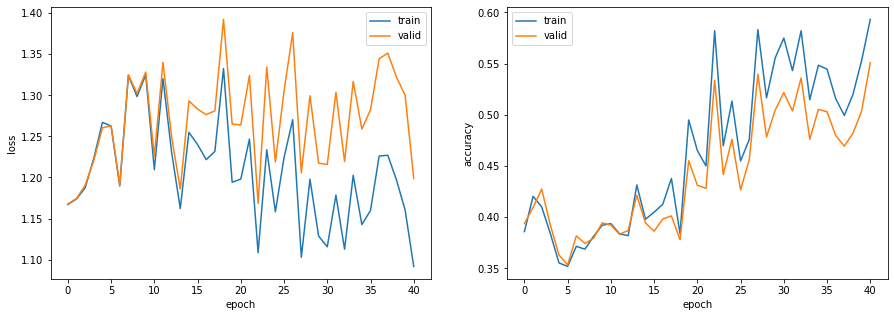

正解率（学習データ）：0.593
正解率（評価データ）：0.552


In [42]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

### #87の方

In [43]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [44]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(dataset), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break
      
    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [45]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))


  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.device('cuda')

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion) 

  return loss_valid 

In [47]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=10800)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2022-01-30 20:15:16,040] A new study created in memory with name: no-name-d8d327fa-7aec-4320-8ee0-ace57428aba6


epoch: 1, loss_train: 1.1640, accuracy_train: 0.4997, loss_valid: 1.1659, accuracy_valid: 0.4723, 11.6693sec


KeyboardInterrupt: 

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = int(trial.params['emb_size'])
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = int(trial.params['out_channels'])
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = trial.params['drop_rate']
LEARNING_RATE = trial.params['learning_rate']
BATCH_SIZE = int(trial.params['batch_size'])
NUM_EPOCHS = 30

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')